In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from easy_vqa import get_train_questions, get_test_questions, get_answers, get_train_image_paths, get_test_image_paths
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# The CNN
im_input = Input(shape=(64, 64, 3))
x1 = Conv2D(8, 3, padding='same')(im_input)
x1 = MaxPooling2D()(x1)
x1 = Conv2D(16, 3, padding='same')(x1)
x1 = MaxPooling2D()(x1)
x1 = Flatten()(x1)
# Add a final fully-connected layer after the CNN for good measure
x1 = Dense(32, activation='tanh')(x1)

In [3]:
# Read questions
# train_qs and test_qs are just arrays of question strings
# (we'll use the other variables later)
train_qs, train_answers, train_image_ids = get_train_questions()
test_qs, test_answers, test_image_ids = get_test_questions()

all_answers = get_answers()
num_answers = len(all_answers)


# Fit tokenizer on the training questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_qs)

# Convert questions to BOW
train_X_seqs = tokenizer.texts_to_matrix(train_qs)
test_X_seqs = tokenizer.texts_to_matrix(test_qs)

# Example BOW:
# [0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
print(train_X_seqs[0])
print(test_qs[:2])

[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0.]
['what is the red shape?', 'what is the color of the triangle?']


In [4]:
# We add one because the Keras Tokenizer reserves index 0 and never uses it.
vocab_size = len(tokenizer.word_index) + 1

# The question network
q_input = Input(shape=(vocab_size,))
x2 = Dense(32, activation='tanh')(q_input)
x2 = Dense(32, activation='tanh')(x2)

In [5]:
from tensorflow.keras.layers import Multiply
out = Multiply()([x1, x2])

In [6]:
out = Dense(32, activation='tanh')(out)
# num_answers will be defined below
out = Dense(num_answers, activation='softmax')(out)

In [7]:
model = Model(inputs=[im_input, q_input], outputs=out)
model.compile(
  Adam(lr=2e-4), # somewhat arbitrarily chosen
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [8]:
def load_and_proccess_image(image_path):
  # Load image, then scale and shift pixel values to [-0.5, 0.5]
  im = img_to_array(load_img(image_path))
  return im / 255 - 0.5

def read_images(paths):
  # paths is a dict mapping image ID to image path
  # Returns a dict mapping image ID to the processed image
  ims = {}
  for image_id, image_path in paths.items():
    ims[image_id] = load_and_proccess_image(image_path)
  return ims

train_ims = read_images(get_train_image_paths())
test_ims = read_images(get_test_image_paths())

In [9]:
# Create model input images
train_X_ims = [train_ims[id] for id in train_image_ids]
test_X_ims = [test_ims[id] for id in test_image_ids]

train_X_ims = np.array(train_X_ims)
test_X_ims = np.array(test_X_ims)

# Create model outputs
train_answer_indices = [all_answers.index(a) for a in train_answers]
test_answer_indices = [all_answers.index(a) for a in test_answers]
train_Y = to_categorical(train_answer_indices)
test_Y = to_categorical(test_answer_indices)

train_Y = np.array(train_Y)
test_Y = np.array(test_Y)

In [10]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

In [11]:
# Train the model!
model.fit(
  
  [train_X_ims, train_X_seqs],
  train_Y,
  validation_data=([test_X_ims, test_X_seqs], test_Y),
  shuffle=True,
  epochs=10,
  callbacks=[checkpoint],
)

Epoch 1/10
1206/1206 [==============================] - 31s 26ms/step - loss: 1.0583 - accuracy: 0.6227 - val_loss: 0.7903 - val_accuracy: 0.6831
Epoch 2/10
1206/1206 [==============================] - 30s 25ms/step - loss: 0.7702 - accuracy: 0.6782 - val_loss: 0.7332 - val_accuracy: 0.6891
Epoch 3/10
1206/1206 [==============================] - 31s 25ms/step - loss: 0.7234 - accuracy: 0.6882 - val_loss: 0.6942 - val_accuracy: 0.6961
Epoch 4/10
1206/1206 [==============================] - 30s 25ms/step - loss: 0.6868 - accuracy: 0.6952 - val_loss: 0.6599 - val_accuracy: 0.7078
Epoch 5/10
1206/1206 [==============================] - 31s 25ms/step - loss: 0.6531 - accuracy: 0.7073 - val_loss: 0.6350 - val_accuracy: 0.7074
Epoch 6/10
1206/1206 [==============================] - 31s 25ms/step - loss: 0.6217 - accuracy: 0.7138 - val_loss: 0.6053 - val_accuracy: 0.7203
Epoch 7/10
1206/1206 [==============================] - 31s 25ms/step - loss: 0.5932 - accuracy: 0.7218 - val_loss: 0.5857 -

In [43]:
load_model = tf.keras.models.load_model("model.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 64, 64, 3)

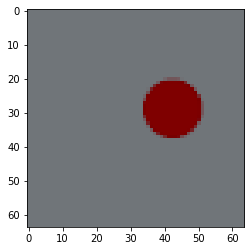

In [53]:
# Take an image from test set

test_image = test_X_ims[100]
plt.imshow(test_image)
test_image = np.array(test_image)
test_image = np.expand_dims(test_image,0)
test_image.shape

In [54]:
# Write a question for the given image

question = ["what is the colour of the object?"]
question_t = tokenizer.texts_to_matrix(question)
question_t = np.array(question_t)
question_t.shape

(1, 27)

In [59]:
one_predictions = load_model.predict([test_image, question_t])

In [60]:
one_predictions

array([[5.6792987e-03, 5.8664818e-04, 5.5997080e-01, 2.0053610e-02,
        8.4755867e-04, 1.1263676e-03, 9.3623877e-02, 6.1474517e-03,
        1.6584281e-04, 2.1778473e-03, 2.5677326e-01, 5.1906653e-02,
        9.4075518e-04]], dtype=float32)

In [61]:
np.argmax(one_predictions)

2

In [62]:
all_answers[np.argmax(one_predictions)]


'red'

In [50]:
# evalution
predictions = load_model.predict([test_X_ims, test_X_seqs])

# Stats for each answer
for idx in range(num_answers):
	pred_values = predictions[:, idx]
	answer = all_answers[idx]
	print(f'\nStatistics for answer {idx}, {answer}')
	min = np.amin(pred_values)
	max = np.amax(pred_values)
	mean = np.mean(pred_values)
	print(f'Min: {min}, Max: {max}, Mean: {mean}')




Statistics for answer 0, circle
Min: 2.9436811018968e-05, Max: 0.5361816883087158, Mean: 0.04237091913819313

Statistics for answer 1, green
Min: 1.4614980727856164e-06, Max: 0.6708670854568481, Mean: 0.019010111689567566

Statistics for answer 2, red
Min: 1.542876816529315e-05, Max: 0.7949628233909607, Mean: 0.01737716607749462

Statistics for answer 3, gray
Min: 1.7878837752505206e-05, Max: 0.40366101264953613, Mean: 0.01568651758134365

Statistics for answer 4, yes
Min: 2.0412771846167743e-05, Max: 0.9921601414680481, Mean: 0.36548733711242676

Statistics for answer 5, teal
Min: 1.0776385352073703e-05, Max: 0.6648666262626648, Mean: 0.018261481076478958

Statistics for answer 6, black
Min: 1.3321432561497204e-05, Max: 0.45122161507606506, Mean: 0.017009977251291275

Statistics for answer 7, rectangle
Min: 5.5779502872610465e-05, Max: 0.5286158323287964, Mean: 0.047373831272125244

Statistics for answer 8, yellow
Min: 8.742137538320094e-07, Max: 0.6009628176689148, Mean: 0.015497282

In [51]:
shapes = []
yesno = []
for i in range(num_answers):
  if (all_answers[i] == 'rectangle' or all_answers[i] == 'circle' or all_answers[i] == 'triangle'):
    shapes.append(i)
  elif all_answers[i] == 'yes' or all_answers[i] == 'no':
    yesno.append(i)

def return_class(answer):
  if answer in shapes:
    return 0
  if answer in yesno:
    return 1
  return 2
error_matrix = [[0 for _ in range(3)] for _ in range(3)]
total_errors = 0

color_error_matrix = [[0 for _ in range(num_answers)] for _ in range(num_answers)]
questions_wrong = {}

for idx in range(len(test_answer_indices)):
  # answer numbers for triangle, circle, rectangle
  answer = test_answer_indices[idx]
  pred = np.argmax(predictions[idx])
  if not answer == pred:
    total_errors += 1
    error_matrix[return_class(answer)][return_class(pred)] += 1
    color_error_matrix[answer][pred] += 1
    if (return_class(answer) == 1 and return_class(pred) == 1):
      if test_qs[idx] in questions_wrong:
        questions_wrong[test_qs[idx]] += 1
      else:
        questions_wrong[test_qs[idx]] = 1

print('total error: {}'.format(total_errors / len(test_answer_indices)))
print('Indexes are, in order, shapes, yes/no, colors')
print('Rows are class of answer, columns are class of prediction')
for i in range(3):
  print('{}\t{}\t{}\n'.format(error_matrix[i][0] / total_errors, error_matrix[i][1] / total_errors, error_matrix[i][2]/ total_errors))
print('-------------')
for i in range(num_answers):
  to_print = ''
  for j in range(num_answers):
    to_print += str(color_error_matrix[i][j]) + '\t'
  print(to_print)
print('-------------')
print(questions_wrong)

total error: 0.2585547399979324
Indexes are, in order, shapes, yes/no, colors
Rows are class of answer, columns are class of prediction
0.3158736505397841	0.0	0.0

0.0	0.4958016793282687	0.0

0.0	0.0	0.18832467013194723

-------------
0	0	0	0	0	0	0	195	0	169	0	0	0	
0	0	0	0	0	1	0	0	18	0	0	0	0	
0	0	0	0	0	6	3	0	0	0	14	18	0	
0	0	0	0	0	48	30	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	0	617	
0	0	0	4	0	0	2	0	0	0	0	0	0	
0	0	4	30	0	14	0	0	0	0	11	0	0	
73	0	0	0	0	0	0	0	0	164	0	0	0	
0	141	0	0	0	1	0	0	0	0	4	1	0	
36	0	0	0	0	0	0	153	0	0	0	0	0	
0	0	85	2	0	4	23	0	0	0	0	3	0	
0	0	1	0	0	1	0	0	0	0	2	0	0	
0	0	0	0	623	0	0	0	0	0	0	0	0	
-------------
{'is a triangle present?': 25, 'is there a blue shape?': 10, 'is a yellow shape present?': 12, 'does the image not contain a yellow shape?': 11, 'is a circle present?': 31, 'is there not a circle in the image?': 24, 'is there not a brown shape?': 15, 'is there a circle?': 32, 'is there a black shape?': 12, 'is there not a black shape?': 10, 'is no black shape present?': 9